Variational Autoencoder for the MNIST dataset using Pytorch

In [63]:
import math

import matplotlib.pyplot as plt
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [64]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)


In [65]:
from torch import nn
from torch.nn import functional as F

class Encoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, hidden_dim, kernel_size=3, stride=2, padding=1) # 32, 14, 14
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=3, stride=2, padding=1) # 64, 7, 7
        self.conv3 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=7) # 128, 1, 1
        
        self.fc_mean = nn.Linear(hidden_dim * 4, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim * 4, latent_dim)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv3(x)
        x = F.leaky_relu(x, 0.2)
        
        x = x.view(x.size(0), -1)
        
        mu = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        
        return mu, logvar

In [66]:
class Decoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        super().__init__()
                
        self.fc = nn.Linear(latent_dim, hidden_dim * 4)
        self.transpose1 = nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=7)
        self.transpose2 = nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.transpose3 = nn.ConvTranspose2d(hidden_dim, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
         
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, x.size(1), 1, 1)
        x = F.leaky_relu(x, 0.2)
        x = self.transpose1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.transpose2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.transpose3(x)
        x = F.sigmoid(x)
        return x

In [67]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std


class VariationalAutoencoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(hidden_dim, latent_dim)
        self.decoder = Decoder(hidden_dim, latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE, KLD

In [68]:
latent_dim = 4
hidden_dim = 8
model = VariationalAutoencoder(hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print(model)


VariationalAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1))
    (fc_mean): Linear(in_features=32, out_features=4, bias=True)
    (fc_logvar): Linear(in_features=32, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=4, out_features=32, bias=True)
    (transpose1): ConvTranspose2d(32, 16, kernel_size=(7, 7), stride=(1, 1))
    (transpose2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (transpose3): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)


In [69]:
num_epochs = 25
outputs = []
recon_losses = []
kld_losses = []
total_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_recon_loss = 0
    epoch_kld_loss = 0
    epoch_total_loss = 0
    for img, _ in data_loader:
        img = img.to(device)
        recon, mu, logvar = model(img)
        recon_loss, kld_loss = vae_loss(recon, img, mu, logvar)
        loss = recon_loss + kld_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_recon_loss += recon_loss.item()
        epoch_kld_loss += kld_loss.item()
        epoch_total_loss += loss.item()
    
    scheduler.step()
    
    # Berechne Durchschnittsverluste für diese Epoche
    avg_recon_loss = epoch_recon_loss / len(data_loader)
    avg_kld_loss = epoch_kld_loss / len(data_loader)
    avg_total_loss = epoch_total_loss / len(data_loader)
    
    # Speichere die Verluste
    recon_losses.append(avg_recon_loss)
    kld_losses.append(avg_kld_loss)
    total_losses.append(avg_total_loss)
    
    print(f"Epoch: {epoch}, Recon Loss: {avg_recon_loss:.4f}, KLD Loss: {avg_kld_loss:.4f}, Total Loss: {avg_total_loss:.4f}")
    outputs.append((epoch, img.cpu(), recon.cpu()))

Epoch: 0, Recon Loss: 9219.7464, KLD Loss: 527.9632, Total Loss: 9747.7096
Epoch: 1, Recon Loss: 8407.7816, KLD Loss: 571.2162, Total Loss: 8978.9978
Epoch: 2, Recon Loss: 8341.0946, KLD Loss: 581.2224, Total Loss: 8922.3170
Epoch: 3, Recon Loss: 8293.5907, KLD Loss: 587.6073, Total Loss: 8881.1980
Epoch: 4, Recon Loss: 8254.1561, KLD Loss: 590.9841, Total Loss: 8845.1402
Epoch: 5, Recon Loss: 7804.3381, KLD Loss: 601.4223, Total Loss: 8405.7603
Epoch: 6, Recon Loss: 7745.1638, KLD Loss: 609.4874, Total Loss: 8354.6512
Epoch: 7, Recon Loss: 7715.7483, KLD Loss: 613.0057, Total Loss: 8328.7540
Epoch: 8, Recon Loss: 7691.4471, KLD Loss: 617.4323, Total Loss: 8308.8794
Epoch: 9, Recon Loss: 7668.8505, KLD Loss: 619.1947, Total Loss: 8288.0452
Epoch: 10, Recon Loss: 7602.4989, KLD Loss: 621.9089, Total Loss: 8224.4077
Epoch: 11, Recon Loss: 7590.2488, KLD Loss: 624.6135, Total Loss: 8214.8622
Epoch: 12, Recon Loss: 7585.8044, KLD Loss: 624.1867, Total Loss: 8209.9912
Epoch: 13, Recon Loss:

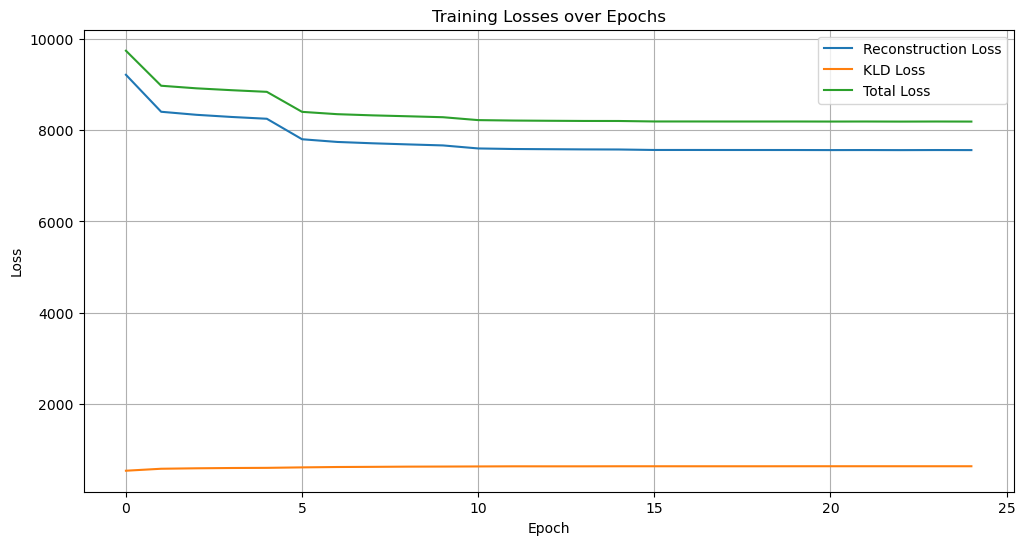

In [70]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(num_epochs), recon_losses, label='Reconstruction Loss')
plt.plot(range(num_epochs), kld_losses, label='KLD Loss')
plt.plot(range(num_epochs), total_losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses over Epochs')
plt.legend()
plt.grid(True)
plt.show()

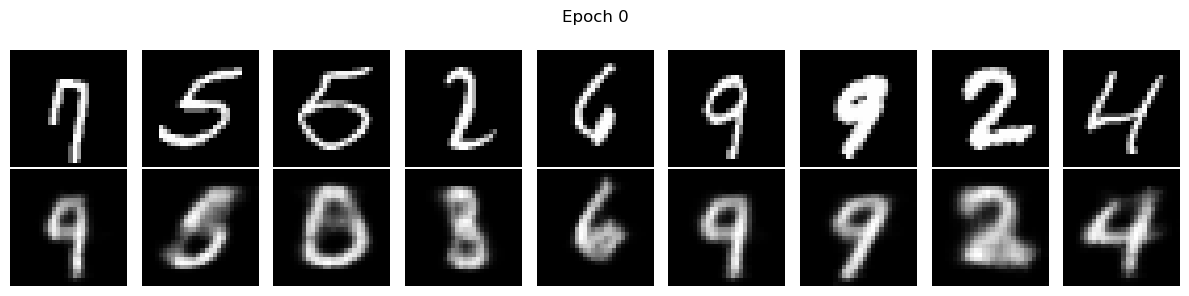

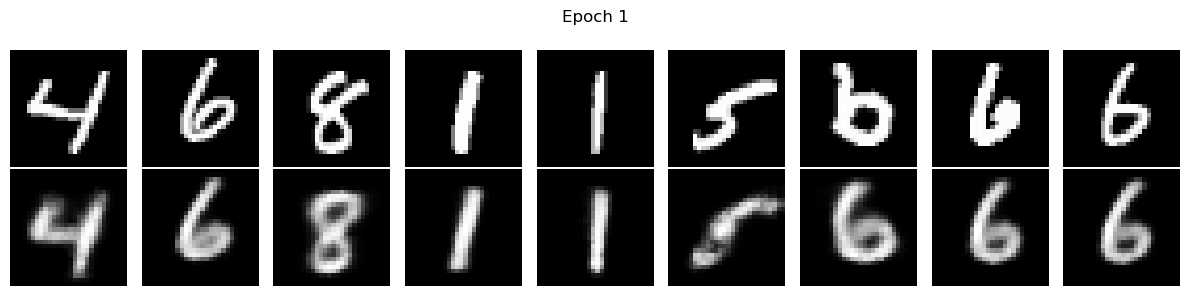

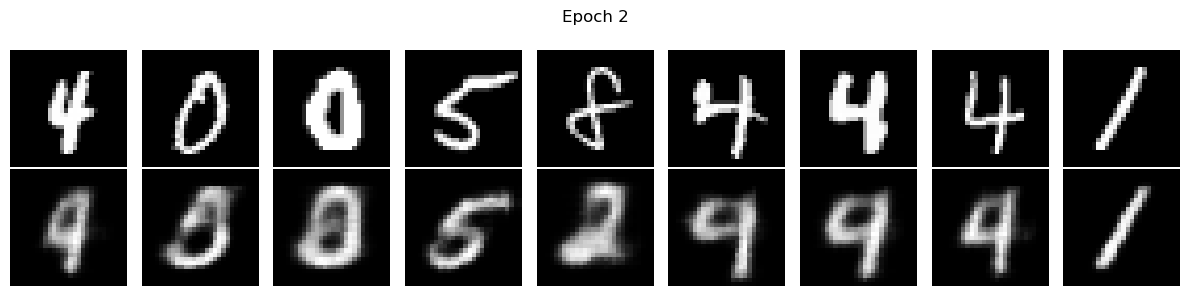

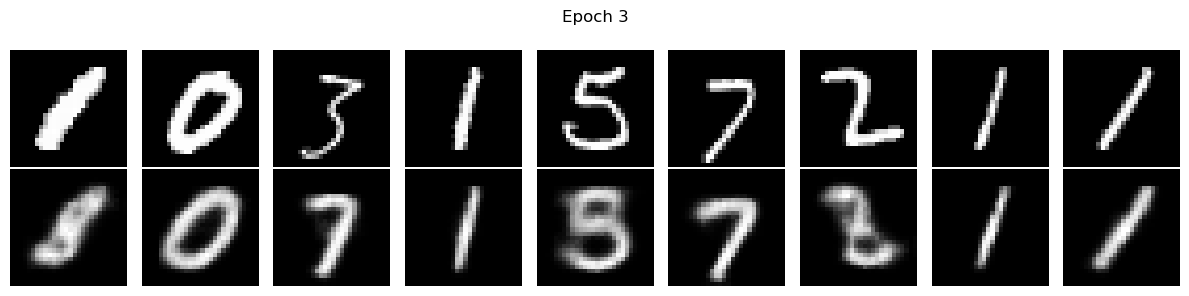

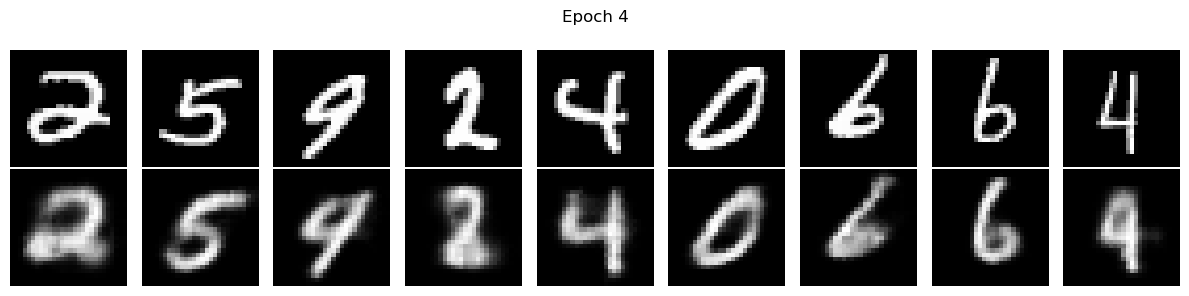

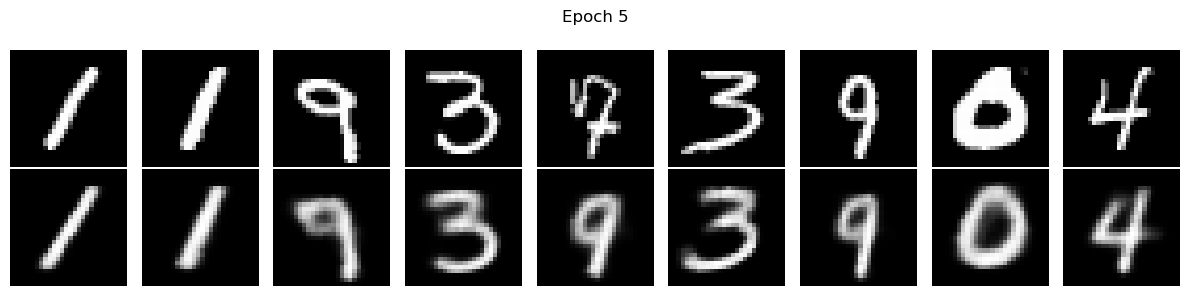

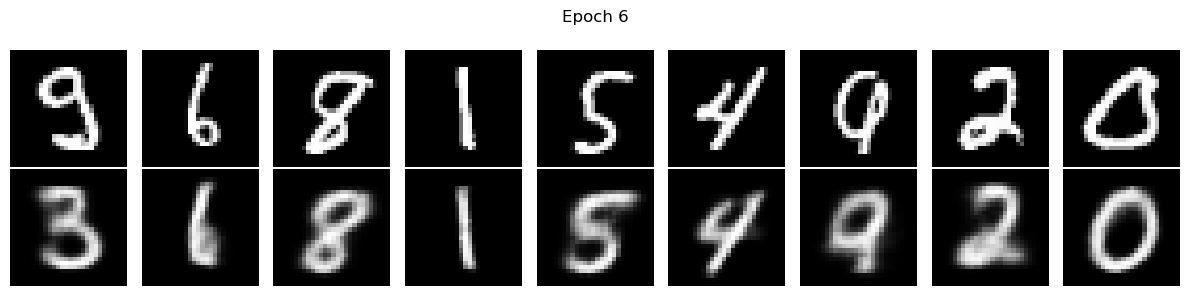

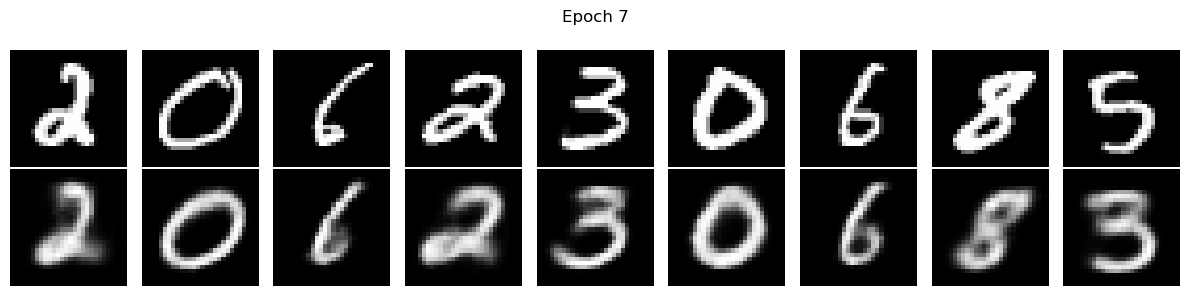

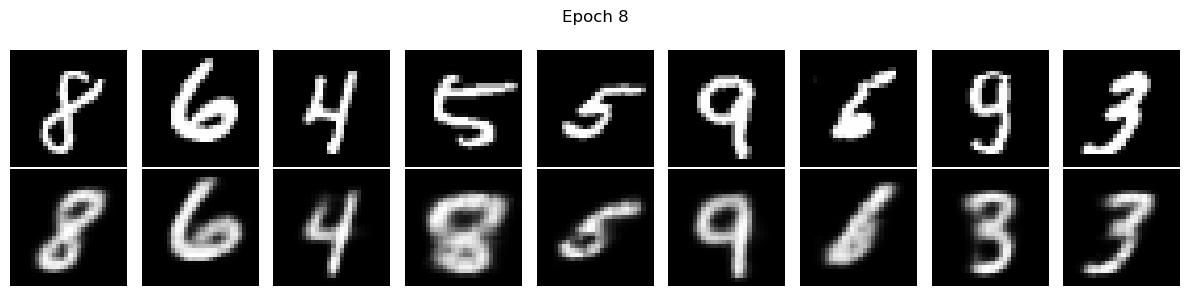

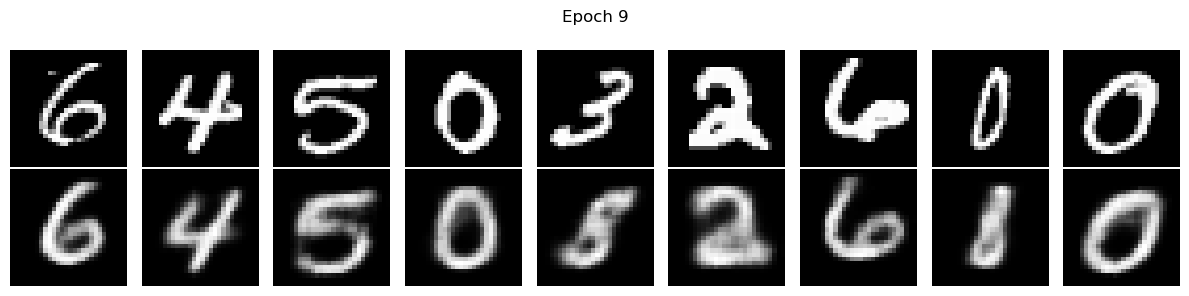

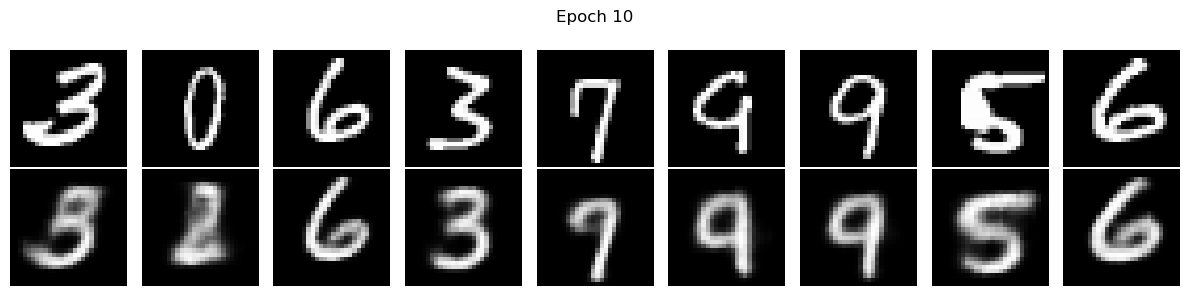

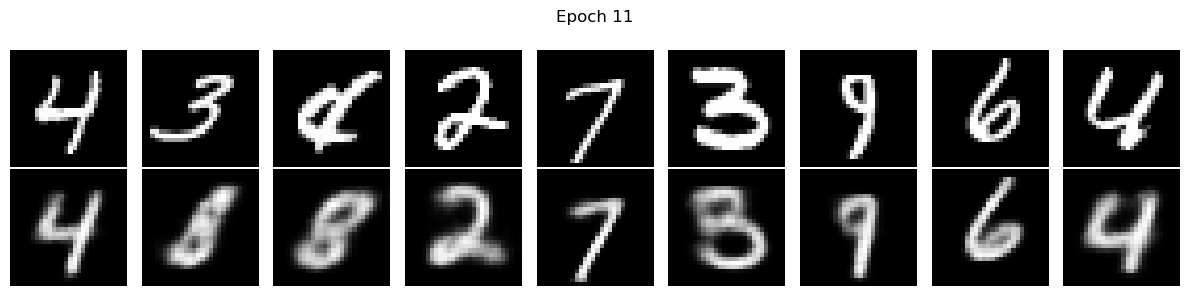

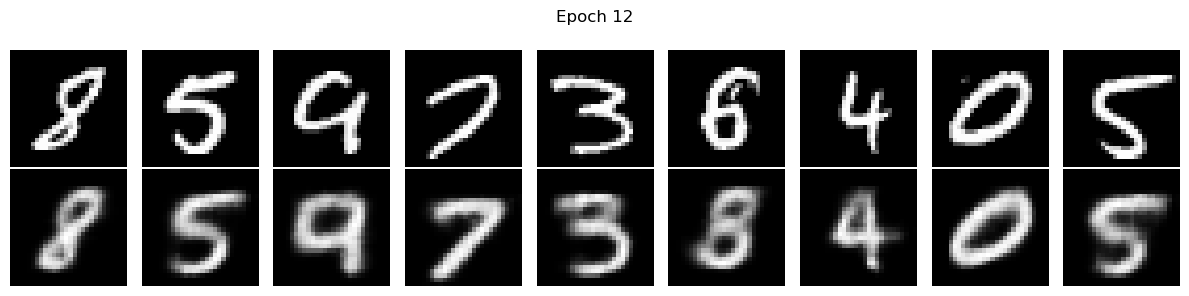

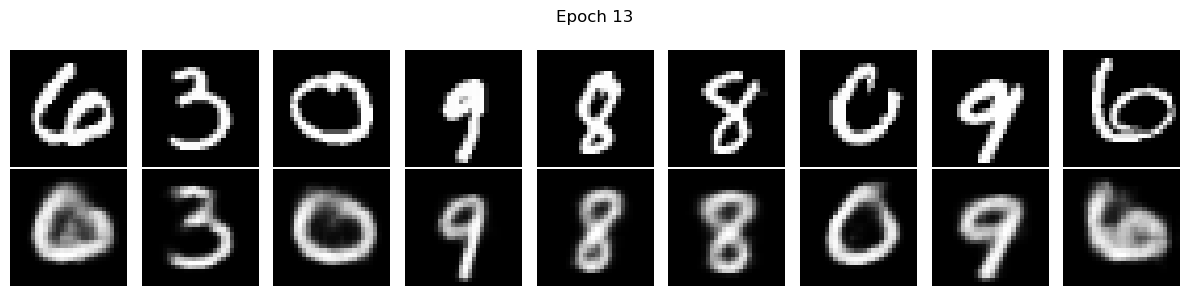

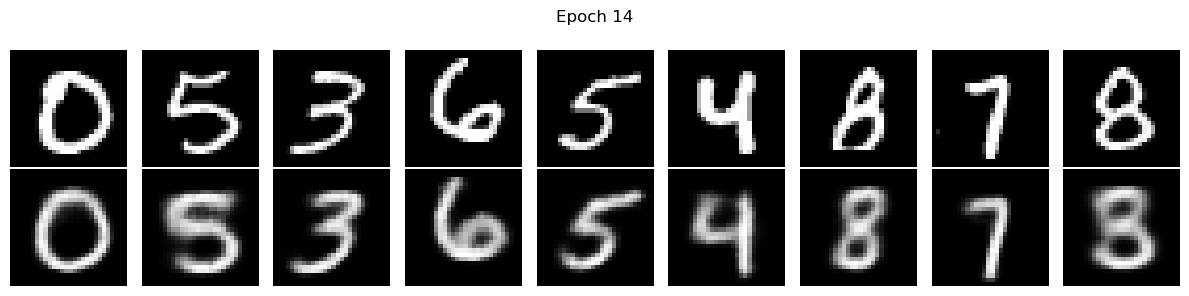

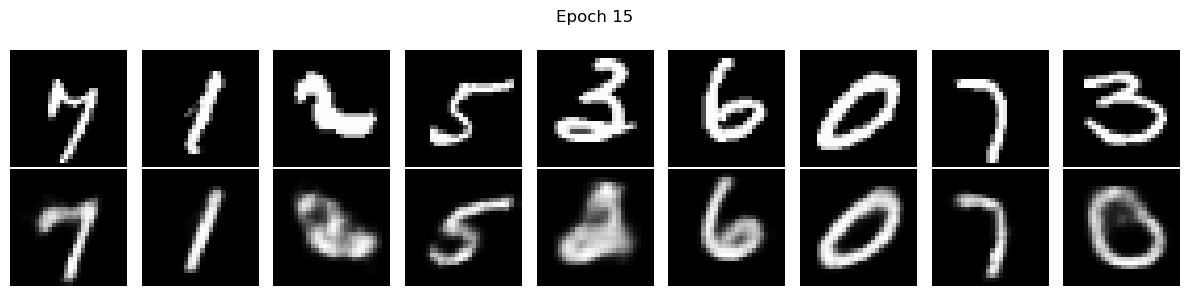

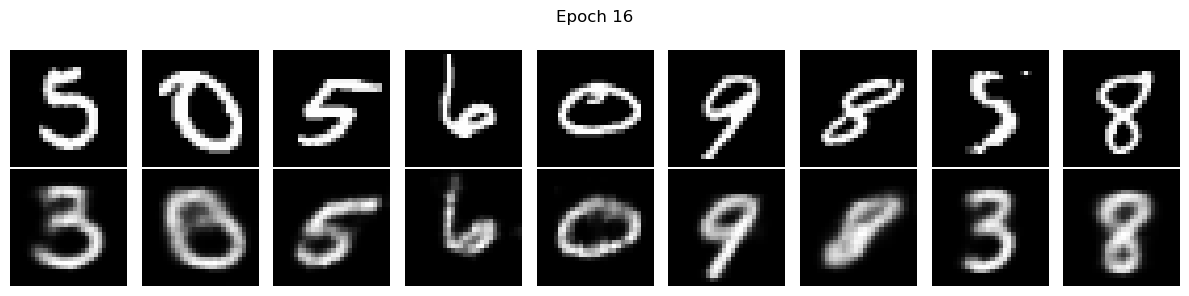

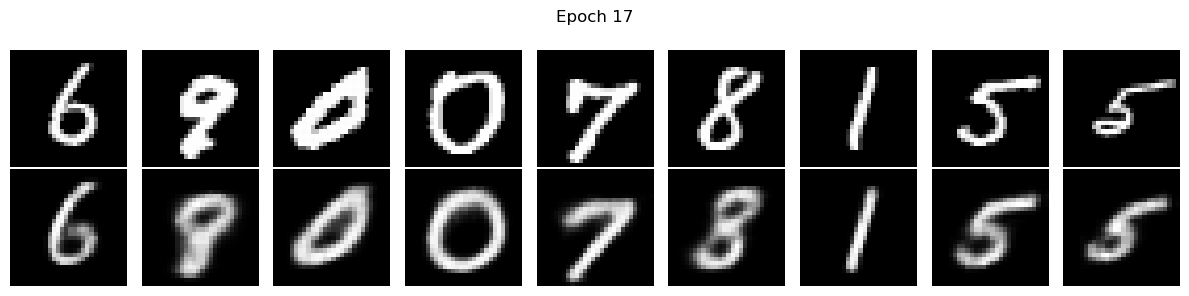

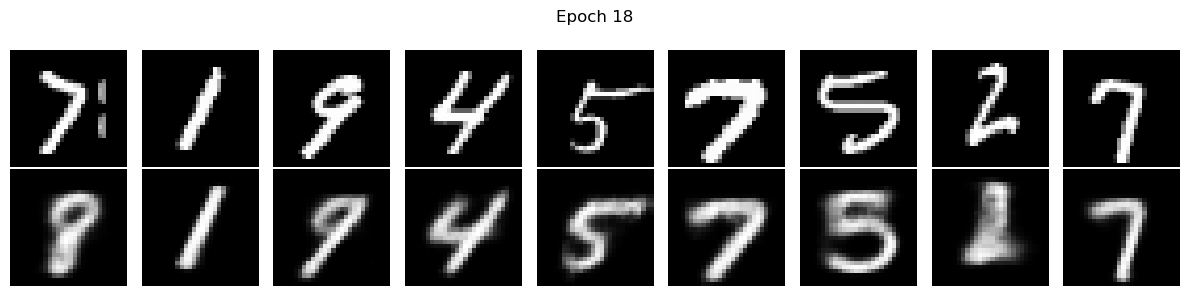

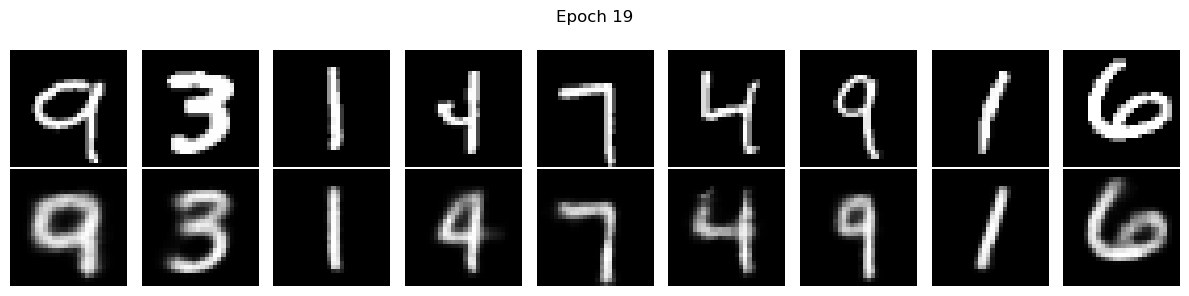

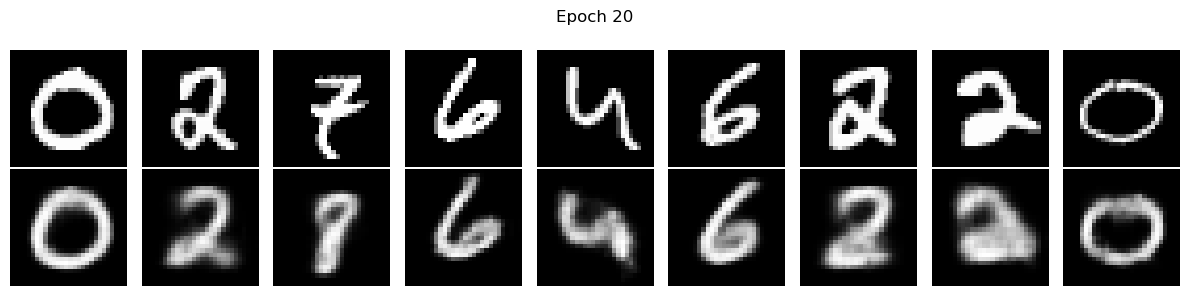

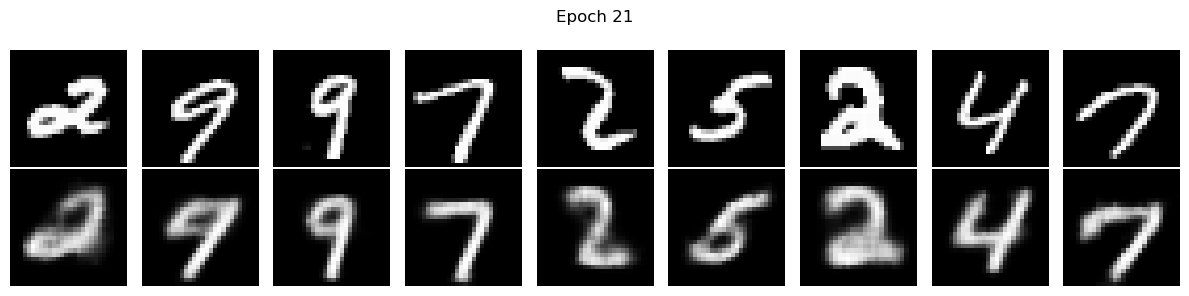

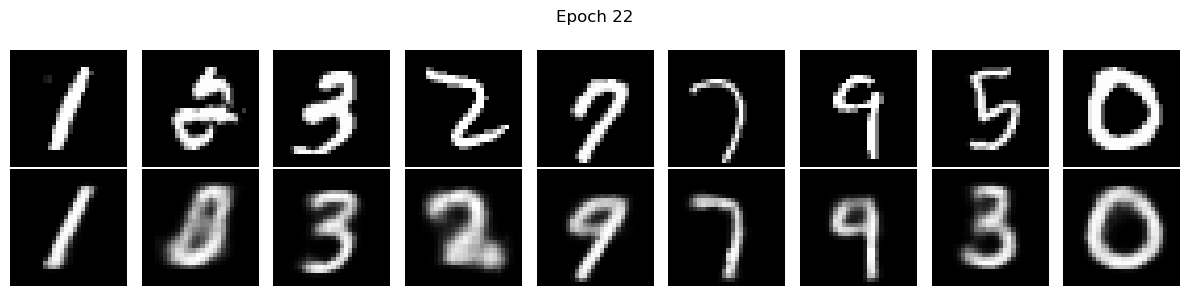

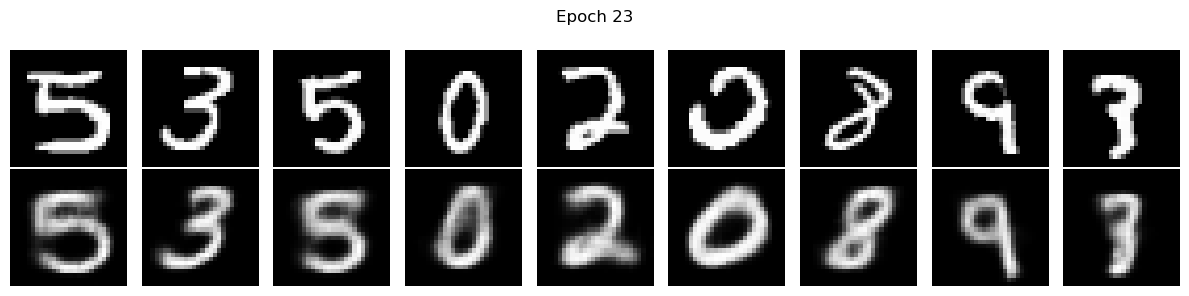

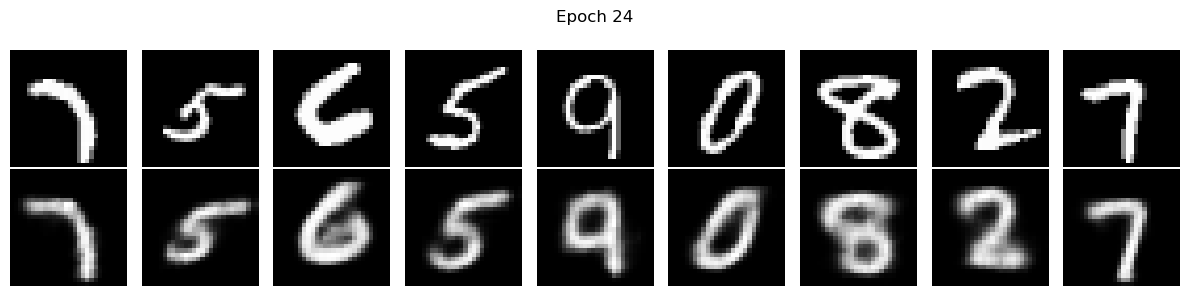

In [71]:
model.eval()
for k, (epoch, imgs, recon) in enumerate(outputs):
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"Epoch {epoch}")
    plt.gray()
    
    for i in range(9):
        plt.subplot(2, 9, i+1)
        plt.imshow(imgs[i][0])
        plt.axis('off')
    
    for i in range(9):
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(recon[i][0].detach().numpy())
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

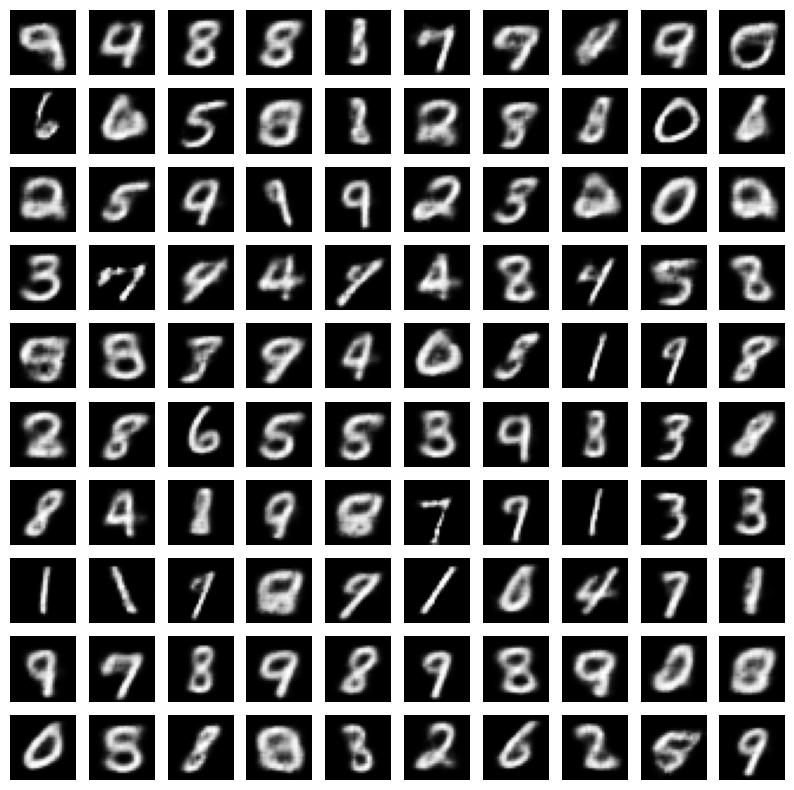

In [72]:
samples = 100

with torch.no_grad():
    random_latents = torch.randn(samples, latent_dim).to(device)
    generated_images = model.decoder(random_latents)
    
generated_images = generated_images.cpu().numpy().reshape(-1, 28, 28)

plt.figure(figsize=(10, 10))

for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')
    
plt.show()
